In [1]:
import ase
import time
import sys
import torch
from torch.nn import MSELoss
from skorch import NeuralNetRegressor
from skorch.dataset import CVSplit
from skorch.callbacks import Checkpoint, EpochScoring
from skorch.callbacks.lr_scheduler import LRScheduler
from amptorch.gaussian import SNN_Gaussian
from amptorch.model import FullNN, CustomLoss, MAELoss
from amptorch.data_preprocess import AtomsDataset, factorize_data, collate_amp, TestDataset
from md_work.md_utils import md_run, calculate_energies, calculate_forces, time_plots, kde_plots
from amptorch.skorch_model import AMP
from amptorch.skorch_model.utils import target_extractor, energy_score, forces_score
from amptorch.lj_model import lj_optim
from torch.utils.data import DataLoader
from torch.nn import init
from skorch.utils import to_numpy
import numpy as np
from ase import Atoms, units
from ase.calculators.emt import EMT
import matplotlib.pyplot as plt
import random

import skorch.callbacks.base
class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('./results/checkpoints/forces_best_params.pt')

In [2]:
def resample_images(base_images, sample_images, num_samples):
    random.seed(3)
    sample_points = random.sample(range(1, len(sample_images)), num_samples)
    file1 = open("resample_log.txt", "a")
    file1.write(str(sample_points) + "\n")
    file1.close()
    images = base_images.copy()
    for idx in sample_points:
        sample_images[idx].set_calculator(EMT())
        images.append(sample_images[idx])
    return images

In [3]:
ber_images = ase.io.read("../datasets/COCu_ber_100ps_300K.traj", ":2000:10")

mllj_images = ase.io.read("./ber_results/COCu_mdfix_lbfgs_200s_LJ.traj", ":")
mllj_images1 = ase.io.read("./ber_results/COCu_mdfix_lbfgs_200s_LJ_100_iter_1.traj", ":")
mllj_images2 = ase.io.read("./ber_results/COCu_mdfix_lbfgs_200s_LJ_100_iter_2.traj", ":")
mllj_images3 = ase.io.read("./ber_results/COCu_mdfix_lbfgs_200s_LJ_100_iter_3.traj", ":")

num_samples = 100
resampled_lj_images = resample_images(ber_images, mllj_images, num_samples)
resampled_lj_images1 = resample_images(resampled_lj_images, mllj_images1, num_samples)
resampled_lj_images2 = resample_images(resampled_lj_images1, mllj_images2, num_samples)
resampled_lj_images3 = resample_images(resampled_lj_images2, mllj_images3, num_samples)

# define symmetry functions to be used
Gs = {}
Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
Gs["G2_rs_s"] = [0] * 4
Gs["G4_etas"] = [0.005]
Gs["G4_zetas"] = [1.0, 4.0]
Gs["G4_gammas"] = [+1.0, -1]
Gs["cutoff"] = 5.876798323827276 #EMT asap_cutoff: False

In [4]:
# LJ Optimization
def lj_optimization(images, Gs, label):
    cutoff = Gs["cutoff"]
    a=12
    p0 = [
        8.34971967e-1,
        1.11853403e1,
        -4.47321611e-4,
        9.46645818e-1,
        8.94249846,
        -2.51039757e-3,
        2.37853521,
        0.17514104,
        -0.00376541,
        33.84674966934952
    ]
    params_dict = {"C": [], "O": [], "Cu": []}
    lj_model = lj_optim(images, p0, params_dict, cutoff, label, forcesonly=True)
    fitted_params = p0
#     fitted_params = lj_model.fit()
    lj_energies, lj_forces, num_atoms = lj_model.lj_pred(
        images, fitted_params, params_dict
    )
    lj_data = [
        lj_energies,
        lj_forces,
        num_atoms,
        fitted_params,
        params_dict,
        lj_model,
    ]
    return lj_data

In [5]:
label_lj = "parity_test"
lj_data = lj_optimization(resampled_lj_images3, Gs, label_lj)
forcetraining = True
training_lj_data = AtomsDataset(resampled_lj_images3, SNN_Gaussian, Gs, forcetraining=forcetraining,
        label=label_lj, cores=10, lj_data=lj_data, scaling='minmax')
unique_atoms = training_lj_data.elements
fp_length = training_lj_data.fp_length
scalings = training_lj_data.scalings
print(scalings)

Calculating fingerprints...
Fingerprints Calculated!
[tensor(0.5062), tensor(8.3804)]


In [6]:
LR_schedule = LRScheduler('CosineAnnealingLR', T_max=5)
cp = Checkpoint(monitor='forces_score_best', fn_prefix='./results/checkpoints/forces_best_')
load_best_valid_loss = train_end_load_best_valid_loss()
device = "cpu"

net = NeuralNetRegressor(
    module=FullNN(unique_atoms, [fp_length, 3, 20], device, forcetraining=forcetraining),
    criterion=CustomLoss,
    criterion__force_coefficient=0.04,
    optimizer=torch.optim.LBFGS,
    lr=1e-1,
    batch_size=len(training_lj_data),
    max_epochs=10,
    iterator_train__collate_fn=collate_amp,
    iterator_train__shuffle=True,
    iterator_valid__collate_fn=collate_amp,
    iterator_valid__shuffle=False,
    device=device,
    train_split=CVSplit(cv=5, random_state=1),
    callbacks=[
       EpochScoring(
            forces_score,
            on_train=False,
            use_caching=True,
            target_extractor=target_extractor,
        ),
        EpochScoring(
            energy_score,
            on_train=False,
            use_caching=True,
            target_extractor=target_extractor,
        ), cp, load_best_valid_loss, LR_schedule
    ],
)

In [7]:
# Define calculator and train
net.initialize()  # This is important!
net.load_params(f_params='./results/trained_models/COCu_mdfix_lbfgs_200s_LJ_100_iter_4.pt')
calc_lj = AMP(training_lj_data, net, label="COCu_mdfix_lbfgs_200s_LJ_100_iter_4")

In [10]:
%matplotlib inline

def make_figures(calc, images):
    import seaborn as sns
    actual_energies = np.array([image.get_potential_energy(apply_constraint=False) for image in images])
    pred_energies = [calc.get_potential_energy(image) for image in images]
    lims = [8, 10]
    energy_fig = sns.jointplot(
        pred_energies, actual_energies, kind="hex", bins="log", extent=lims + lims
    )
    ax1 = energy_fig.ax_joint
    _ = ax1.set_xlim(lims)
    _ = ax1.set_ylim(lims)
    _ = ax1.plot(lims, lims, "--")
    _ = ax1.set_xlabel("ML Energy, eV")
    _ = ax1.set_ylabel("Target Energy, eV")
    
    actual_forces = np.concatenate(
    np.array([image.get_forces() for image in images])
    )
    pred_forces = np.concatenate(
        np.array([calc.get_forces(image) for image in images])
    )

    lims = [-5, 5]
    force_fig = sns.jointplot(
        pred_forces, actual_forces, kind="hex", bins="log", extent=lims + lims
    )
    ax2 = force_fig.ax_joint
    _ = ax2.set_xlim(lims)
    _ = ax2.set_ylim(lims)
    _ = ax2.plot(lims, lims, "--")
    _ = ax2.set_xlabel("ML Forces, eV/A")
    _ = ax2.set_ylabel("Target Forces, eV/A")

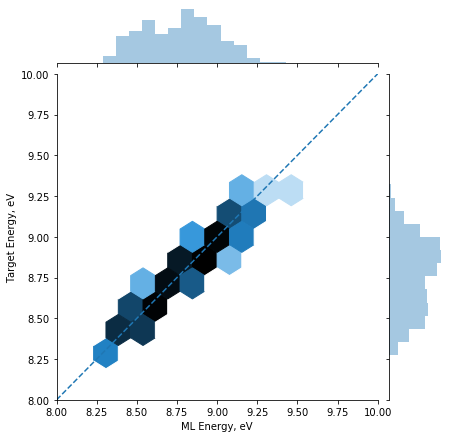

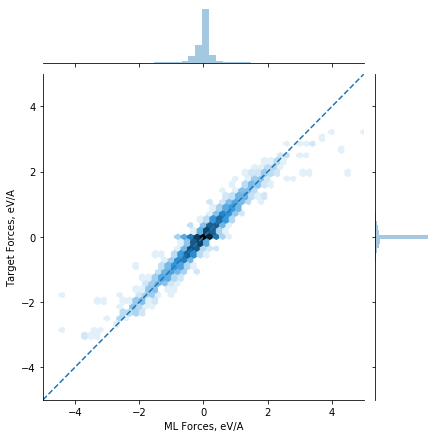

In [11]:
make_figures(calc_lj, resampled_lj_images3)